## Supervised vs. Unsupervised Training

The sorts of problems we've seen so far in this class are examples of __supervised training__. 

Supervised training is training model on a dataset with both predictor and response variables in order to get a model that can predict the response in the future, when we supply just the predictors.

There are also other kinds of problems, including __unsupervised training__, where we are modeling data for which we do not have labels ("ground truth" response variable data).

#### How can we possibly build a model without any true response data?

Most unsupervised learning is about discovering patterns in data -- 

1. either in relation it other data points (e.g., where are records mostly similar vs. where are outliers or anomalies in the data, something useful for fraud, instrusion, or process-failure detection)
2. or in relation to some constant, external standards (e.g., we could learn about the contents of bright vs. dark photos by using a simple heuristic [instead of labeling] for deciding what is "bright"; we could then look for commonalities within the two groups)

#### Clustering

The most common unsupervised patterns for business applications are forms of clustering, or determining which sets of data points are most similar.

* As noted above, anomaly detection for fraud, quality control, etc. are a form of "1 group" clustering (where we measure coherence to the central normative group) or n-group clustering (where one large group is taken as normative, and others represent types of deviation)
* Clustering algorithms are also widely used for customer segmentation, as part of a recommendation workflow, etc.
* Clustering is often more subtle and tricky than it seems ... "obvious" groupings and allegiances can turn out to be a distraction, and most companies are unable to successfully address the many power-law-distributed clusters that make up the long tail of their customer base, even when most of their value derives from these smaller groups.
* As with other algorithms, there are hyperparameters to be tuned -- i.e., subjective human input applied -- when performing unsupervised learning. I.e., even unsupervised learning is not 100% "objective."

#### K-Means Example

A common clustering algoithm is K-Means, which attempts to partition the data into K (where a human supplies K as a hyperparameter) distinct clusters in a coherent way. Suppose we hypothesized that our diamond sales fell into 3 natural categories -- say, small and cheap; large, rare, and expensive; and some sort of middle group. We could run K-Means on the data ... and the we would need to carefully analyze the results to see if they match our hypothesis at all.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('data/diamonds.csv')
df2 = df.drop(df.columns[0], axis=1)
df3 = pd.get_dummies(df2)

y = df3.iloc[:,3]
X = df3.drop(df3.columns[3], axis=1)

In [2]:
from sklearn.cluster import KMeans

cluster_labels = KMeans(n_clusters=3).fit_predict(X)

cluster_labels

array([1, 0, 0, ..., 0, 2, 1], dtype=int32)

In [3]:
kdf = pd.DataFrame(data=np.column_stack([cluster_labels, y]), columns=['cluster', 'price'])
print([kdf[kdf.cluster==n]['price'].mean() for n in range(0,3)])

[3771.8742861326696, 1353.926625562989, 7445.93177511055]


### Dimensionality Reduction

Another popular form of unsupervised learning is called dimensionality reduction.

If our featurized data records are points in a high-dimensional space, dimensionality reduction is the process of trying to find a good representation of that same data in lower-dimensional space. This is equivalent to representing the data with a smaller number of features, which may be more meaningful. We may even believe that all of the information we care about lies in a low-dimensional, well-behaved subspace of our original data (this is called the "manifold hyptothesis").

The catch, of course, is that we'd like to not lose import aspects of the data when we do this, where "important" is defined as the information we need to make good classifications or regressions or other analytics conclusions.

<img src="https://materials.s3.amazonaws.com/i/aiOUoim.png" width=700>

This can be an __unsupervised learning__ activity when we use an algorithm to try and find the low-dimensional structure or approximation of our dataset, without any labels or special classes being defined.

Not all dimensionality reduction is linear, as in the diagram above, but one popular linear algorithm is Principal Component Analysis or PCA.

PCA aims to identify linear components of the data space which account for "most" of the variance in the data. We can choose how many components to retain, in order of decreasing variance (information).

If you're crafting these representations yourself, why is it important? On the data engineering side, just as with feature selection, reduced dimensionality may offer a big reduction in data and model size, as well as a big increase in speed. On the other hand, performing PCA on a large dataset can be expensive, depending on the number of records, number of features, and algorithm used. Scalable singular-value decomposition ("SVD"), a matrix factorization, is one common approach when records have large numbers of features (e.g., in Apache Spark's data-parallel model: https://spark.apache.org/docs/2.3.0/mllib-dimensionality-reduction.html#singular-value-decomposition-svd)

Here we'll take a look at a small example that illustrates the concept, using our iris dataset:

In [4]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA

iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.92461872 0.05306648]


In [5]:
pca.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

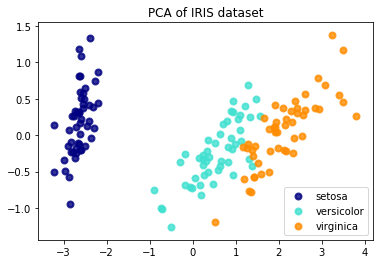

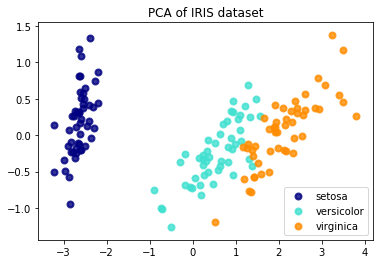

In [6]:
fig = plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

display(fig)

### Nonlinear Dimensionality Reduction (Manifold Learning)

__Manifold Hypothesis__

Algorithms: https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Manifold_learning_algorithms

*How might this work?*

Example: https://umap-learn.readthedocs.io/en/latest/how_umap_works.html

For an example with UMAP (and GPU acceleration!) see the GPU_vs_CPU_UMAP notebook

### Dimensionality Reduction of Discrete Data (Embeddings)

Consider a high-cardinality set of discrete items. Tokens (as used in NLP) are a canonical example.

Brute force approaches (a dimension per 1-hot encoded word) won't work. Shortcuts (count vectors, Hashing TF-IDF) can help but are not perfect. 

What if ... 
* we didn't have to spend dimensions on many unique words that mean the same thing?
* we could normalize words by sense, or find similarity by sense?
* even use the "sense vectors" of words across different languages? 

#### Let's discuss *Word Embeddings*

__We'll start with word vectors__

<img src="https://materials.s3.amazonaws.com/i/iWzuElv.png">

#### But ... how?!

There are several approaches to training word vectors. One is training them as __embedding matrices__ using __noise-contrastive estimation__ and n-ngram prediction tasks.

Variations on this technique are fundamental to SOTA NLP work, and can even work across languages!

<img src="https://materials.s3.amazonaws.com/i/ig1Uytr.jpg" width=900>